#  Emotion Detetction

In [9]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version", tf.__version__)

Tensorflow version 2.15.0


# **Importing Libraries**

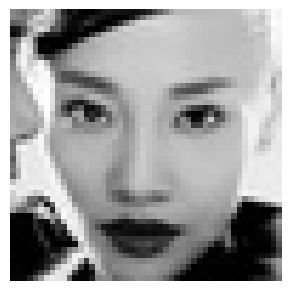

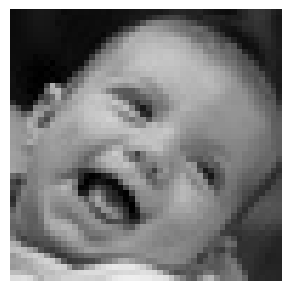

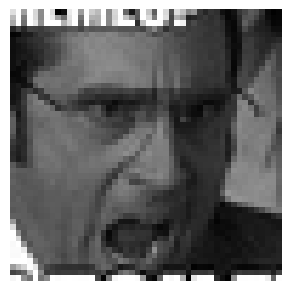

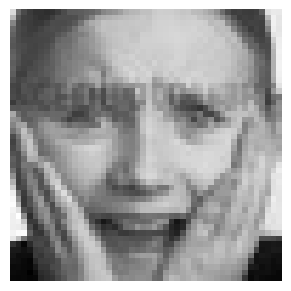

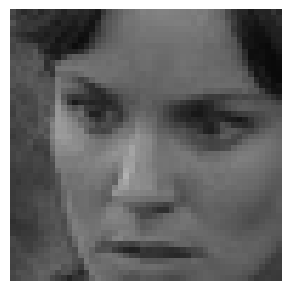

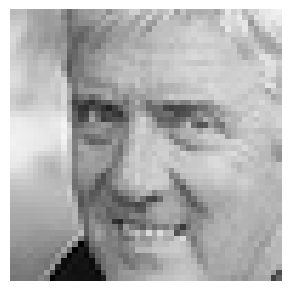

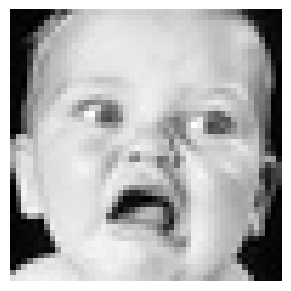

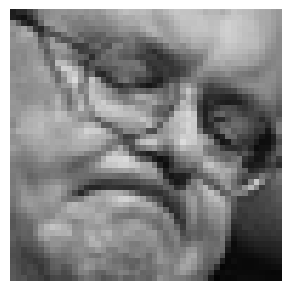

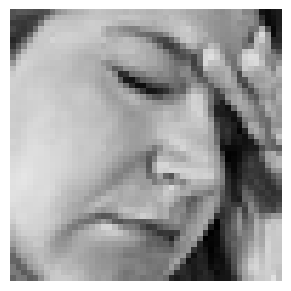

In [10]:
images = glob("train/**/**")
for i in range (9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

 preparing data for training

In [11]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator()
train_validation = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [13]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [14]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output =Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    model.compile(loss  = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [15]:
model = model_fer((48,48,1))
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 128)       0    

In [16]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = train_validation.n//train_validation.batch_size
check = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", save_weights_only= True, mode= "max", verbose=1)
callbacks=[check]

In [17]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = train_validation,
    validation_steps = validation_steps,
    callbacks = callbacks
)

Epoch 1/15


448/448 [==============================] - ETA: 0s - loss: 1.6552 - accuracy: 0.3787
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 482s 1s/step - loss: 1.6552 - accuracy: 0.3787 - val_loss: 1.8731 - val_accuracy: 0.2838
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3465 - accuracy: 0.4900
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 183s 407ms/step - loss: 1.3465 - accuracy: 0.4900 - val_loss: 1.9837 - val_accuracy: 0.2751
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.1931 - accuracy: 0.5581
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 132s 295ms/step - loss: 1.1931 - accuracy: 0.5581 - val_loss: 1.4947 - val_accuracy: 0.4263
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.0568 - accuracy: 0.6078
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 1

In [18]:
model.evaluate(train_validation)

113/113 [==============================] - 6s 53ms/step - loss: 1.9311 - accuracy: 0.4953


[1.931086778640747, 0.49526330828666687]

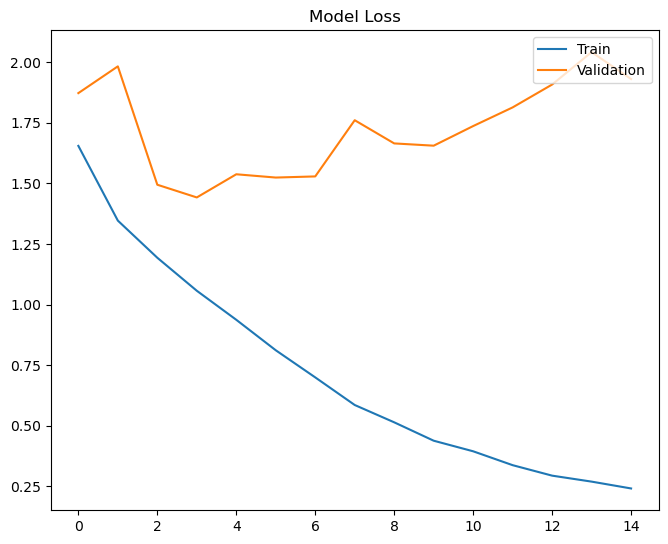

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'],loc = 'upper right')
plt.subplots_adjust(top=1.0, bottom= 0.0, right = 0.95, left = 0.0, hspace=0.25, wspace=0.35)


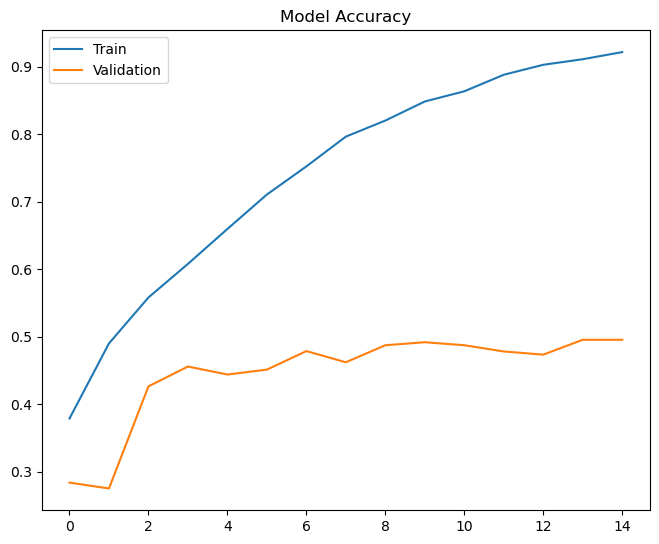

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom=0.0, right=0.95, left = 0.0, hspace=0.25, wspace=0.35)

In [21]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)